# JPEG Compression

- Valérian FAYT <valerian.fayt>
- Romain HERMARY <romain.hermary>
- Quentin LE HELLOCO <quentin.le-helloco>

## Project

#### In this notebook, you have to:
* Illustrate and comment every different step of your algorithm, like if you had to explain it to someone who never heard of JPEG.
* Implement and analyses all relevant tests to demonstrate the proper functioning of the algorithm.

#### Your JPEG code should at least:
* Manage color, leaving the choice to the user to compress in RGB or YUV, as well as the sub-sampling options (4:4:4, 4:2:2 and 4:2:0) of chrominance.
* Manage images whose dimensions are not 8 multiples
* Let the user choose the quality indicator q for the luminance quantification matrix.
* Return for each macro-block, a compression indicator. This indicator may be define as in the course (number of coefficient by macro-block to code without compression (64) divide by the number of coefficient not null after zigzag linearisation of the DCT quantified matrix). It can be any other relevant indicator as well, if the choice is justified.

#### Bonus:
* Implement the conversion of DCT coefficients after quantification by Huffman table.

### JPEG Algorithm

* Step 1 :
Split images in 8x8 blocks (if not multiple, add new columns/row with symmetrical inputs.

* Step 2 :
Apply DCT matrix (don't forget to -128)

* Step 3 :
Quantification of the matrix

* Step 4 :
Zigzag + Huffman compression

(Reversible to uncompress JPEG as well)

### Import

In [3]:
import numpy as np
from PIL import Image

### Get list of pixel from Image

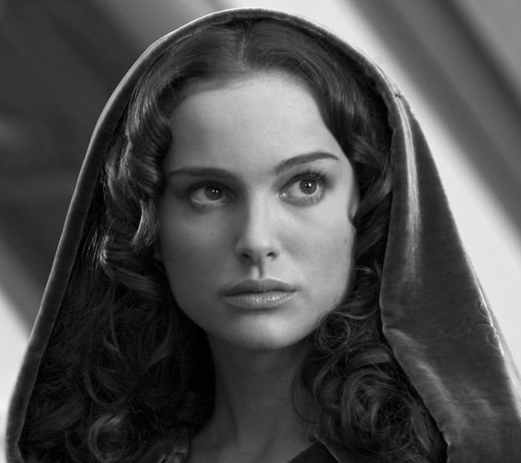

In [4]:
im = Image.open('Images/amidala_crop.png', 'r')
im = im.convert("L")
im

In [90]:
# data = np.asarray(im)
#you can create images from array like that (rot90) for this one ->
#rotate = Image.fromarray(np.rot90(data), 'L')

### Image Split

If the image is not a multiple of 8, make it one by adding row and cells.
Divide the image into macro-block of 8x8pixels.

In [5]:
def split(data):
    """
    Split a multiple of 8 image into 8x8 macro block list
    """
    
    blocks = []
    
    for i in range(0, data.shape[0], 8):
        for j in range(0, data.shape[1], 8):
            
            block = [[], [], [], [], [], [], [], []]
            
            for a in range (i, i + 8):
                for b in range (j, j + 8):
                    block[a - i].append(data[a][b])
                    
            blocks.append(block)
    return blocks

In [38]:
def multiple_8(matrix):
    """
    Make any dimension image into a multiple of 8 by adding rows and columns
    by border pixels mirroring
    """
    
    a, b = matrix.shape
    print('Dimension:', matrix.shape)

    if a % 8 != 0 or b % 8 != 0 :
        print("Need padding...")
    else:
        return matrix

    padding_a = 8 - a % 8
    padding_b = 8 - b % 8

    # If the number of pixels to add on one line or a column, it is problematic
    print("Padding:", padding_a, padding_b)
    if padding_a > a or padding_b > b:
        print("Error: cannot do mirror padding, for now")
        return matrix
    
    matrix = matrix.tolist()
    
    # Mirror the pixels on the lines by copying and reversing the pixel line
    for i in range(a):
        tmp = matrix[i][b - padding_b:].copy()
        tmp.reverse()
        matrix[i] += tmp
    
    # Mirror the border lines starting from the bottom
    for i in range(padding_a):
        matrix.append(matrix[a - 1 - i])
    
    matrix = np.array(matrix)
    print('New Dimension:', matrix.shape)

    return matrix.astype('uint8')

In [39]:
test = np.arange(1, 127)
test = test.reshape(9, 14)

test = multiple_8(test)
print(test)

Dimension: (9, 14)
Need padding...
Padding: 7 2
New Dimension: (16, 16)
[[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  14  13]
 [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  28  27]
 [ 29  30  31  32  33  34  35  36  37  38  39  40  41  42  42  41]
 [ 43  44  45  46  47  48  49  50  51  52  53  54  55  56  56  55]
 [ 57  58  59  60  61  62  63  64  65  66  67  68  69  70  70  69]
 [ 71  72  73  74  75  76  77  78  79  80  81  82  83  84  84  83]
 [ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  98  97]
 [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112 112 111]
 [113 114 115 116 117 118 119 120 121 122 123 124 125 126 126 125]
 [113 114 115 116 117 118 119 120 121 122 123 124 125 126 126 125]
 [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112 112 111]
 [ 85  86  87  88  89  90  91  92  93  94  95  96  97  98  98  97]
 [ 71  72  73  74  75  76  77  78  79  80  81  82  83  84  84  83]
 [ 57  58  59  60  61  62  63  64  65  66  67  68  69  70

Dimension: (463, 521)
Need padding...
Padding: 1 7
New Dimension: (464, 528)


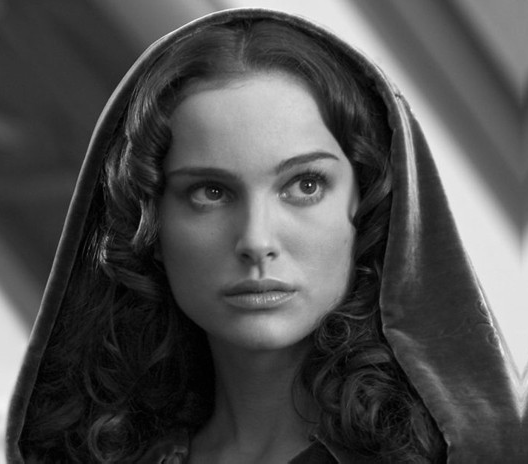

In [49]:
# Load the image into a numpy matrix
data = np.asarray(im)

# Make the matrix dimensions multiples of 8
data = multiple_8(data)
img = Image.fromarray(data, 'L')
display(img)

# Cut into macro-block
macro_blocks = split(data)

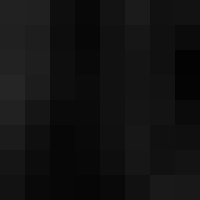

[[33, 32, 14, 8, 19, 27, 17, 18],
 [32, 29, 13, 7, 17, 22, 16, 11],
 [34, 30, 14, 9, 17, 20, 16, 3],
 [37, 28, 14, 11, 17, 20, 18, 4],
 [33, 21, 10, 10, 17, 21, 19, 11],
 [27, 15, 7, 9, 16, 23, 16, 15],
 [21, 12, 7, 8, 14, 22, 17, 19],
 [18, 9, 7, 6, 9, 17, 25, 24]]

In [44]:
# See a macro-block
len(macro_blocks)
block = macro_blocks[3479]
test_block = np.array(block)
test_macro = Image.fromarray(test_block, 'L')

test_macro = test_macro.resize((200,200), resample=0)
display(test_macro)
block

### Apply DCT matrix

explain here

### Quantification of the matrix

Explain here

### Zigzag + Huffman

Explain here

In [ ]:
def zigzag(matrix):
    x, y = 0, 0
    a, b = 7, 7
    direction = (0, 0)
    res = []
    
    while x != a and y != b:
        res.append(matrix[x][y])
        if y == b:
            res.append(matrix[x + 1][y])
            y -= 1
            x += 2
            direction = (1, -1)
        elif x == 0:
            res.append(matrix[x][y + 1])
            x -= 1
            direction = (1, -1)
        else:
            (x, y) += direction
            
            

### RGB - YUV 
Explain here